# Multilabel Classification - Multi-layer Perceptron Classifier 
# 500 Bands

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#DataViz
import seaborn as sns

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from collections import Counter
from imblearn.over_sampling import SMOTE
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

#NN
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D
from tensorflow.keras import utils

#ICA
from sklearn.decomposition import FastICA

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import balanced_accuracy_score, classification_report

#MPL
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.options.display.max_columns = None

## Nulls

some bandwiths are nulls in all data because information about water absorption has been cleaned.

In [7]:
df = pd.read_csv('../data/GHISACONUS_2008_small.csv')

df.dropna(axis = 1, how = 'all', inplace= True)

df.isnull().sum().sum()

0

In [10]:
df = df[df['Stage'] != 'Harvest']
#df.drop(no_harvest, inplace= True)

## Preprocessing

### Prepare the Target

In [15]:
df['Label'] = [','.join(i) for i in zip(df["Crop"],df["Stage"])]

features = [col for col in df.columns if col.startswith('X')]

X = df[features]
z = df['Label']

X.shape, z.shape

((6762, 50), (6762,))

## Resampling by Crop AND Stage

### Train Test Split

In [16]:
#Split dataset
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2, random_state = 18)

## Independent Component Analysis

In [18]:
transformer = FastICA()

Fitted_ICA = transformer.fit(X_train)

### Transform ICA

Upsample and ICA of data for combination of crop and stage

In [19]:
X_test = Fitted_ICA.transform(X_test)

### SMOTE on Train

In [28]:
oversample = SMOTE()

X_train, z_train = oversample.fit_resample(X_train, z_train)

X_train = Fitted_ICA.transform(X_train)

upsample_y = pd.DataFrame(z_train)

#split z_train and dummify
upsample_y[['Crop','Stage']] = upsample_y['Label'].str.split(',',expand=True)

crop_dummy = pd.get_dummies(upsample_y['Crop'], prefix= 'Ycrop_')
stage_dummy = pd.get_dummies(upsample_y['Stage'], prefix= 'Ystage_')

#add the dummies to the df
upsample_y = pd.concat([upsample_y,crop_dummy, stage_dummy], axis = 1)

upsample_y.drop(columns=['Label', 'Crop', 'Stage'], inplace=True)

target = [col for col in upsample_y.columns if col.startswith('Y')]
#target_2 = ['Crop', 'Stage'] 
y_train = upsample_y[target]

X_train.shape, y_train.shape

((13460, 50), (13460, 10))

### Encoding y_test

In [29]:
y_test_df = pd.DataFrame(z_test)

In [30]:
#split z_train and dummify
y_test_df[['Crop','Stage']] = y_test_df['Label'].str.split(',',expand=True)

In [31]:
crop_dummy = pd.get_dummies(y_test_df['Crop'], prefix= 'Ycrop_')
stage_dummy = pd.get_dummies(y_test_df['Stage'], prefix= 'Ystage_')

#add the dummies to the df
y_test_df = pd.concat([y_test_df,crop_dummy, stage_dummy], axis = 1)

In [32]:
target = [col for col in y_test_df.columns if col.startswith('Y')]
#target_2 = ['Crop', 'Stage'] 
y_test = y_test_df[target]

In [35]:
X_test.shape, y_test.shape

((1353, 50), (1353, 10))

## MLP Classification

From ***Parallel Classification of Hyperspectral Images Using Neural Network*** - p. 193 *Computational Intelligence for Remote Sensing*

### Multilabel

In [40]:
#Initializing the MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(128,256, 512, 256),
                    max_iter=1000,
                    activation = 'relu',
                    alpha=1e-4,
                    solver='adam',
                    random_state=42,
                    verbose=1)

clf.fit(X_train, y_train)

Iteration 1, loss = 5.14020956
Iteration 2, loss = 4.92476884
Iteration 3, loss = 4.20744934
Iteration 4, loss = 3.50765728
Iteration 5, loss = 3.26270394
Iteration 6, loss = 2.98331965
Iteration 7, loss = 2.76126659
Iteration 8, loss = 2.61345241
Iteration 9, loss = 2.45820344
Iteration 10, loss = 2.32695800
Iteration 11, loss = 2.22517876
Iteration 12, loss = 2.14533620
Iteration 13, loss = 2.05002300
Iteration 14, loss = 1.97136989
Iteration 15, loss = 1.91104103
Iteration 16, loss = 1.84259634
Iteration 17, loss = 1.76247841
Iteration 18, loss = 1.68545237
Iteration 19, loss = 1.62133675
Iteration 20, loss = 1.57868095
Iteration 21, loss = 1.55410965
Iteration 22, loss = 1.49735658
Iteration 23, loss = 1.46089254
Iteration 24, loss = 1.43448930
Iteration 25, loss = 1.39825378
Iteration 26, loss = 1.35710418
Iteration 27, loss = 1.34694337
Iteration 28, loss = 1.32369669
Iteration 29, loss = 1.28596088
Iteration 30, loss = 1.26003118
Iteration 31, loss = 1.23277833
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(128, 256, 512, 256), max_iter=1000,
              random_state=42, verbose=1)

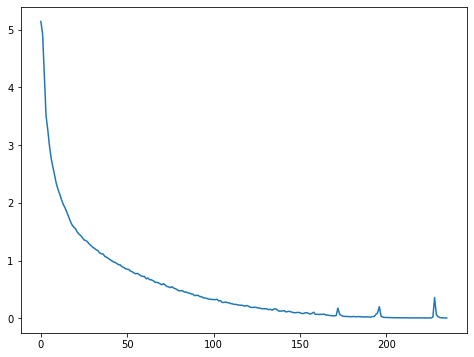

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(clf.loss_curve_);

In [42]:
print(f'Accuracy Score: {round(clf.score(X_test, y_test), 2)*100}%')

Accuracy Score: 73.0%


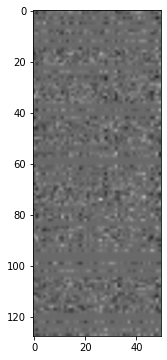

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.imshow(np.transpose(clf.coefs_[0]), aspect="equal",interpolation= 'gaussian', cmap= 'gray');

#### Score

In [44]:
y_labels = ['corn', 'cotton', 'rice', 'soybean',
       'winter_wheat', 'Critical', 'Early_Mid',
       'Emerge_VEarly',  'Late',
       'Mature_Senesc'] #'Harvest',

y_labels_m = ['Corn', 'Cotton', 'Rice', 'Soybean', 'Winter Wheat',
              'Critical', 'Early', 'Mature Senesc']
crop_label = ['Corn', 'Cotton', 'Rice', 'Soybean', 'Winter Wheat']

In [45]:
y_true, y_pred = y_test , clf.predict(X_test)
print('Results on the test set:')
print(classification_report(y_true, y_pred, target_names=y_labels))

Results on the test set:
               precision    recall  f1-score   support

         corn       0.91      0.88      0.89       511
       cotton       0.77      0.81      0.79       153
         rice       0.90      0.93      0.91        28
      soybean       0.87      0.86      0.86       390
 winter_wheat       0.80      0.78      0.79       271
     Critical       0.88      0.90      0.89       368
    Early_Mid       0.84      0.75      0.79       253
Emerge_VEarly       0.77      0.79      0.78       252
         Late       0.88      0.88      0.88       216
Mature_Senesc       0.77      0.77      0.77       264

    micro avg       0.85      0.83      0.84      2706
    macro avg       0.84      0.83      0.84      2706
 weighted avg       0.85      0.83      0.84      2706
  samples avg       0.84      0.83      0.83      2706



### Probability to Determine class

In [46]:
pred_prob = pd.DataFrame(clf.predict_proba(X_test))

In [47]:
pred_prob_crop = np.split(pred_prob, np.arange(5, len(pred_prob.columns), 6), axis=1)[0]
pred_prob_stage = np.split(pred_prob, np.arange(5, len(pred_prob.columns), 6), axis=1)[1]

### Confusion Matrix

In [48]:
cm = multilabel_confusion_matrix(y_test, y_pred)

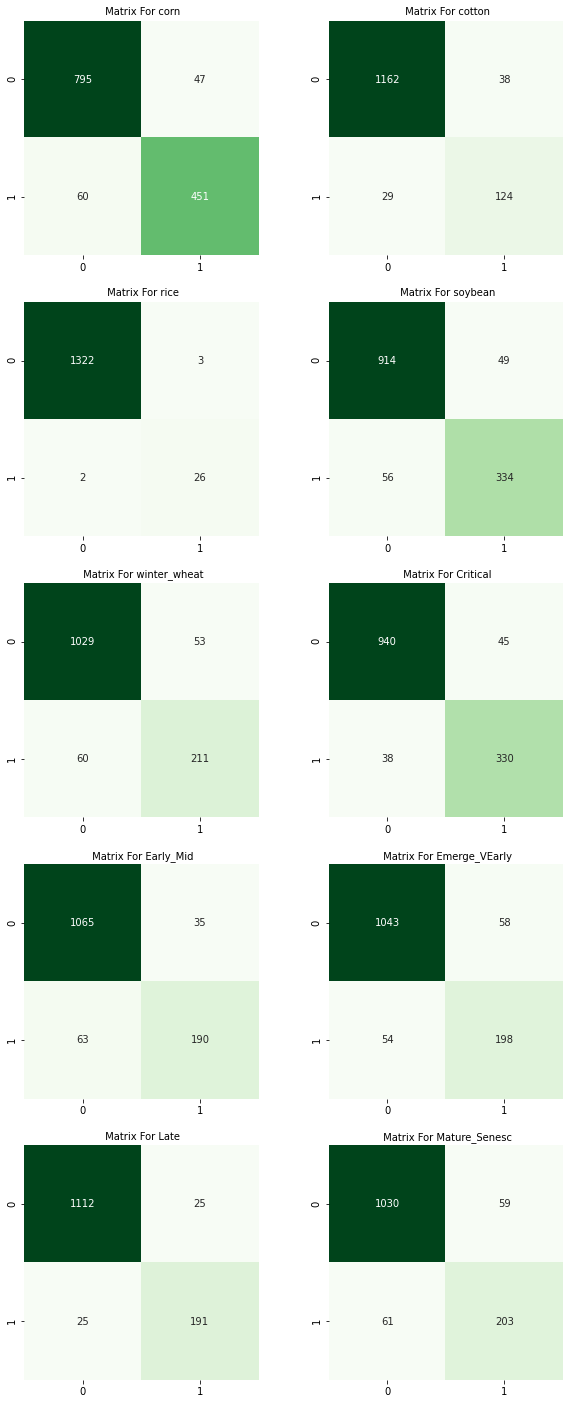

In [54]:
fig, grid_x = plt.subplots(nrows=5, ncols=2, figsize=(10,5*5)) 
grid_x = grid_x.flatten() 

for i in range(0, len(cm)):
    sns.heatmap(pd.DataFrame(cm[i]), annot = True, cmap = 'Greens', fmt = 'd', ax = grid_x[i], square=True, cbar = False)
    grid_x[i].set_title(f' Matrix For {y_labels[i]}', fontsize =10)

In [56]:
mlb = MultiLabelBinarizer(classes = y_labels)

In [57]:
mlb.fit(z_train)

MultiLabelBinarizer(classes=['corn', 'cotton', 'rice', 'soybean',
                             'winter_wheat', 'Critical', 'Early_Mid',
                             'Emerge_VEarly', 'Late', 'Mature_Senesc'])

In [58]:
y_true = y_test.to_numpy()

In [59]:
y_pred = clf.predict(X_test)
y_pred = mlb.inverse_transform(y_pred)

y_true = y_test.to_numpy()
y_true = mlb.inverse_transform(y_true)

In [60]:
index_test = y_test.reset_index()
index_test = index_test.rename(columns = {'index':'og_index'})
index_test['og_index']

0       6144
1       1145
2       6173
3       6190
4       1708
        ... 
1348    4189
1349    5952
1350    4903
1351    2982
1352    5171
Name: og_index, Length: 1353, dtype: int64

In [64]:
dict_wrong = {'index':[],
        'pred':[], 
        'true':[],
        'og_index': []} 

wrong = pd.DataFrame(dict_wrong)
for i, (a, b, c) in enumerate(zip (y_pred, y_true, index_test['og_index'])):
    if a != b:
        new_row = {'index':i,'pred':a, 'true':b, 'og_index': c}
        wrong = wrong.append(new_row, ignore_index=True)

wrong['index'] = wrong['index'].astype(int)

wrong_matrix_list = []
mislabel_true_list = []
for i in wrong['index']:
    wrong_matrix_list.append(y_pred[i])
    mislabel_true_list.append(y_true[i])

In [65]:
wrong.true.value_counts().to_frame().style.bar()

,true
"('winter_wheat', 'Mature_Senesc')",38
"('winter_wheat', 'Emerge_VEarly')",38
"('soybean', 'Early_Mid')",38
"('cotton', 'Early_Mid')",27
"('corn', 'Mature_Senesc')",25
"('soybean', 'Critical')",23
"('corn', 'Emerge_VEarly')",22
"('corn', 'Critical')",19
"('soybean', 'Mature_Senesc')",18
"('corn', 'Early_Mid')",18


In [66]:
wrong.groupby('true')['pred'].value_counts().to_frame().style.bar()

In [462]:
probabiliy_y = pd.DataFrame(clf.predict_proba(X_test))

In [68]:
freq = df.columns.drop(['UniqueID', 'Crop', 'Stage', 'Label'])
df_standard = pd.DataFrame(df.groupby(['Label'])[freq].mean())
df_standard.reset_index(inplace=True)

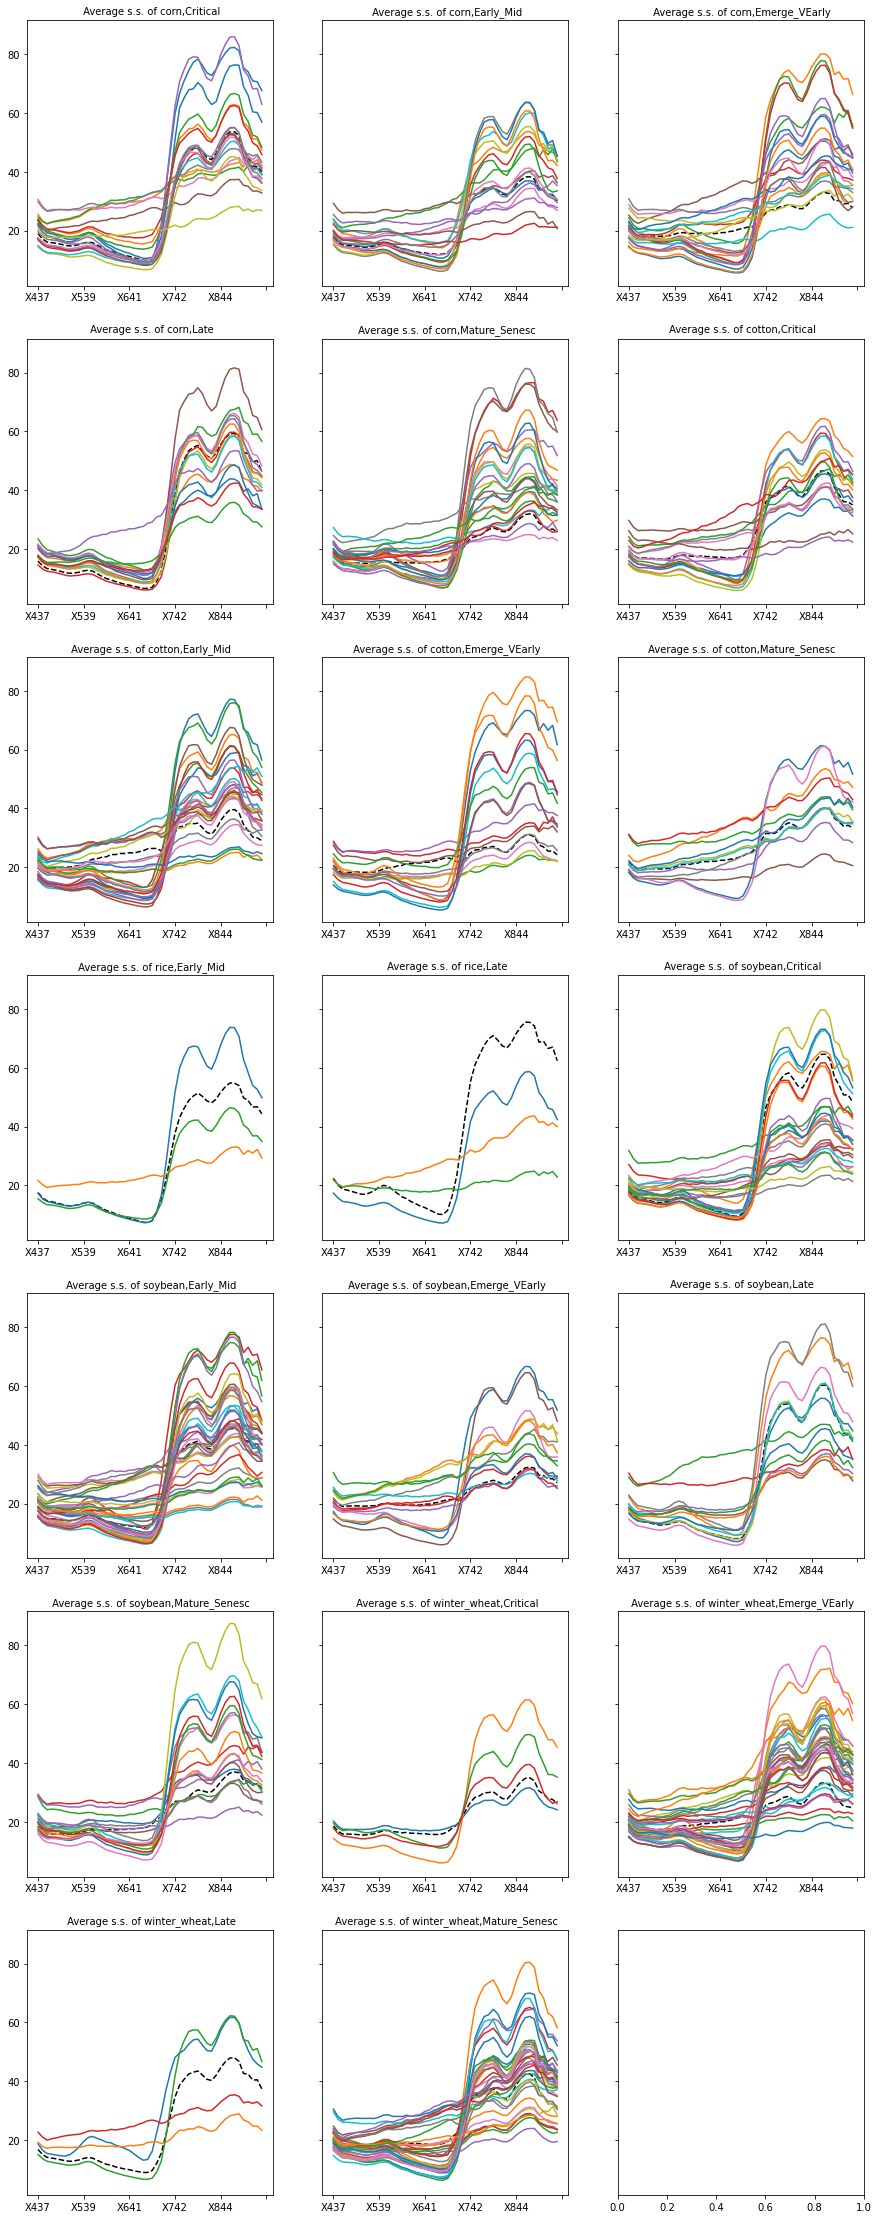

In [69]:
fig, grid_x = plt.subplots(nrows=7, ncols=3, figsize=(15,5*8), sharey='all') 
grid_x = grid_x.flatten() 

for i in range(0, len(df_standard)):
    grid_x[i].set_title(f' Average s.s. of {df_standard.Label[i]}', fontsize =10)
    df_standard.iloc[i].filter(like='X', axis=0).plot(kind='line', ax = grid_x[i], c= 'black', style= '--')
    
    lab = str(df_standard['Label'][i])
    
    for j, w in enumerate(wrong['true']):
        if ','.join(w) == lab:
            index = int(wrong['og_index'][j])
            df.iloc[j].filter(like='X', axis=0).plot(kind='line', ax = grid_x[i])

### Gridsearch

In [255]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [ ]:
mlp_gs = MLPClassifier(max_iter=1000)
parameter_space = {
    'hidden_layer_sizes': [(128,256,256,256)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant','adaptive'],
}
mlp = GridSearchCV(mlp_gs, parameter_space, cv=5, verbose=1)
mlp.fit(X_train, y_train) # X is train samples and y is the corresponding labels
print(f'Accuracy Score: {round(mlp.score(X_test, y_test), 2)*100}%')

In [ ]:
print('Best parameters found:\n', clf.best_params_)

In [ ]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))